In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, BertTokenizer, BertModel
import torch, re
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from pyecharts.charts import Scatter
from pyecharts.charts import Bar
from pyecharts.charts import Pie
from pyecharts import options as opts
from pyecharts.faker import Faker
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib as mpl
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [3]:
MODEL_PATH = '/home/vmice/projects/shibing624/text2vec-base-chinese'
tokenizer = BertTokenizer.from_pretrained('../models/model_zoo/medium')
model = BertModel.from_pretrained('../models/model_zoo/medium')
# sentences = ['如何更换花呗绑定银行卡', '花呗更改绑定银行卡']
test_sentences = ['我想要去加入一个经常旅游的团队，因为我喜欢旅游。',
                  '我们团队平时会偶尔去旅游的。',
                  '经常去旅游的团队我不喜欢去。']
# Tokenize sentences
encoded_input = tokenizer(test_sentences, padding=True, truncation=True, return_tensors='pt')

with torch.no_grad():
    model_output = model(**encoded_input)
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
util.cos_sim(sentence_embeddings, sentence_embeddings)

Some weights of BertModel were not initialized from the model checkpoint at ../models/model_zoo/medium and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'mean_pooling' is not defined

In [4]:
# MODEL_PATH = '../models/model_zoo/medium'
MODEL_PATH = '/home/vmice/projects/sbert-base-chinese-nli'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = SentenceTransformer(MODEL_PATH, device=device)

test_sentences = ['我想要去加入一个经常旅游的团队，因为我喜欢旅游。',
                  '我们团队平时会偶尔去旅游的。',
                  '经常去旅游的团队我不喜欢去。']
# input_ = tokenizer(test_sentences, truncation=True, return_tensors="pt")
# input_
test_sentences = model.encode(test_sentences)
util.cos_sim(test_sentences, test_sentences)

No sentence-transformers model found with name /home/vmice/projects/sbert-base-chinese-nli. Creating a new one with MEAN pooling.


tensor([[ 1.0000,  0.5753, -0.0318],
        [ 0.5753,  1.0000,  0.0974],
        [-0.0318,  0.0974,  1.0000]])

In [5]:
job_csv_file = '../datasets/result1-1.csv'

job_data = pd.read_csv(job_csv_file, encoding='GBK')
print('job data shape', job_data.shape)

job data shape (1254, 14)


In [6]:
job_data.head(3)

,序号,招聘信息 ID,企业名称,企业类型,招聘岗位,薪资范围,招募类型,期望学历,工作年数,招募人数,岗位类型,技能需求,公司地址,工作福利
0,1,1631112859897430016,深圳市海柔创新科技有限公司,"['电子商务', '互联网']",技术服务工程师,"[5000, 10000]",全职,大专,不限,5,"['互联网', '人工智能']",[],广东省深圳市,"['餐饮补贴', '专业培训', '弹性工作']"
1,2,1629824814967554048,广州太普软件科技有限公司,"['互联网', '软件']",大数据分析师（BI）,"[4500, 7000]",全职,本科,不限,1,"['互联网', '软件']",[],广东省广州市,"['餐饮补贴', '专业培训', '弹性工作']"
2,3,1613439889204969472,广州奇之信息技术有限公司,"['互联网', '数据服务']",自然语言处理工程师,"[2000, 4000]",实习,本科,不限,0,['自然语言'],"['算法研究', '深度学习']",广东省广州市,[]


## 招聘信息

### 学历要求

In [23]:
edu_counter = job_data['期望学历'].value_counts()
edu_counter_index = edu_counter.index.to_list()
edu_counter_index

['本科', '大专', '硕士', '不限', '技工']

In [24]:
edu_sorted_index = ['不限', '技工', '大专', '本科', '硕士']
edu_counter_count = [int(edu_counter[index]) for index in edu_sorted_index]
edu_sorted_index, edu_counter_count

(['不限', '技工', '大专', '本科', '硕士'], [9, 9, 215, 980, 41])

In [25]:
edu_bar = (
    Bar(init_opts=opts.InitOpts(width="800px", height="600px"))
    .add_xaxis(edu_sorted_index)
    .add_yaxis('数据', edu_counter_count)
    .set_global_opts(title_opts={"text": "学历要求"})
)
edu_bar.render_notebook()

### 公司类型

In [49]:
company_counter = job_data['企业类型'].value_counts()
company_counter_index = company_counter.index.to_list()
company_counter_count = [int(company_counter[index]) for index in company_counter_index]
# company_counter_index

In [56]:
company_sorted_dict_ = {} # {label: count}

for idx, company_types in enumerate(company_counter_index):
    company_types = eval(company_types)
    for company_type in company_types:
        if company_type not in company_sorted_dict_:
            company_sorted_dict_[company_type] = 0
        company_sorted_dict_[company_type] += company_counter_count[idx]
    
_company_count_thr = 10
company_sorted_dict = {'其他': 0}
company_other_types = []
for key, value in company_sorted_dict_.items():
    if value < _company_count_thr:
        company_sorted_dict['其他'] += value
        company_other_types.append(key)
    else:
        company_sorted_dict.update({key: value})

print('其他', company_other_types)
print(list(company_sorted_dict.keys()))
print(company_sorted_dict.values())

其他 ['金融', '计算机软件', '计算机', '医疗', '制造', '通信', '物流', '教育', '服饰', '通讯', '家居', '地产', '人力资源服务', '企业服务', '游戏', '家电', '水利', '广告', '机械', '在线教育', '电子信息', '环境', '医疗健康', '不限', '计量']
['其他', '互联网', '电子商务', '软件', '大数据', '电商', '数据服务', '智能硬件', '通信设备']
dict_values([66, 1238, 120, 53, 39, 23, 26, 11, 11])


In [61]:
company_pie = (
    Pie(init_opts=opts.InitOpts(width="1000px", height="600px"))
    .add("", [list(z) for z in zip(list(company_sorted_dict.keys()), company_sorted_dict.values())])
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
    .set_global_opts(title_opts={"text": "公司类型"})
)
company_pie.render_notebook()

### 薪资待遇

In [65]:
wage_counter = job_data['薪资范围'].value_counts()
wage_counter_index = wage_counter.index.tolist()
# wage_counter_index

In [34]:
position_classes = {
    
}

In [20]:
position_type = {
    '管理': ['助理', '主管', '经理', '总监'],
    '开发': ['开发', '研发', '前端', '后端', '数据库', '架构', '测试', '运维', '安全', '移动'],
}

In [9]:
position_data_items = job_data['招聘岗位'].unique()
position_data_items

array(['技术服务工程师', '大数据分析师（BI）', '自然语言处理工程师', '爬虫工程师', '团队运营管理实习生',
       '技术文章撰写实习生', '创新俱乐部成员', '解决方案', '大数据架构师', '大数据系统分析师', 'AI类数据标注',
       '大数据开发工程师', '数据工程师', '高级大数据开发工程师HadoopHive', '数据标注工程师', '数据挖掘工程师',
       '数据实施实习生', '数据分析师', '数据产品经理', '交易风控员', '大数据工程师', '数据分析经理',
       '大数据开发实习生', '数仓开发', '实施工程师', '高级业务架构师', 'DataGovernance数据治理',
       '数据分析师助理', '数据开发', '数据报表开发', '数据分析员', '数据处理员', '运维部-Mysql-DBA',
       '大数据运营实习生', '渠道运营总监', '数字化创新人才', '银行数据分析师', '高级数据分析师', '亚马逊数据分析师',
       '数据分析助理初级', '销售经理', '数据开发工程师', 'ETL开发工程师', '产业链数字专员', '数字化工程师',
       '电商战略分析师', '工程师助理', '数据运营专员', '数据分析助理工程师', '遗留判定分析工程师', '遗留数据分析专员',
       '前端工程师', '技术后端', '数据实施工程师', '数据分析助理', '大数据分析师', '数据处理工程师',
       'NLP算法研究员', '商品数据分析专员', '数据处理实习生', '数据分析实习生', '地图数据加工处理专员',
       'AI数据标注师', 'BI数据分析师助理', '数据治理工程师', '电网数据分析实习生', '电商数据分析师',
       '视频数据标注', '运维工程师（大数据）', '在线客服', 'web前端开发工程师', '商务拓展（BD）总监',
       '中国移动10086客户服务代表', '电商数据分析', '运营助理', '电商客服', '成本预算工程师',
       '集团总部-高级数据分析师', '产品专员', '

In [22]:
def process_position_type(positions):
    global position_data_items

    data_items = [None] * len(positions)
    for idx, pos in enumerate(positions):
        data_items[idx] = [item for item in position_data_items if pos in item]
        print(pos, data_items[idx])
        data_operat_index = []
        for item in data_items[idx]:
            data_operat_index += np.where(position_data_items == item)[0].tolist()
        position_data_items = np.delete(position_data_items, data_operat_index)

In [23]:
for position, items in position_type.items():
    process_position_type(items)

助理 ['数据分析师助理', '数据分析助理初级', '工程师助理', '数据分析助理工程师', '数据分析助理', 'BI数据分析师助理', '运营助理', '助理检测师', '销售助理/销售代表', '项目助理岗-广州银行项目', '天猫助理', '电商助理', '产品助理(SX)', '教学助理', '大数据销售助理']
主管 ['高级数据分析师/主管', '大数据产品经理/主管', '数据分析师/数据分析主管', 'CRM主管']
经理 ['数据产品经理', '数据分析经理', '销售经理', 'pmo项目经理', '物流招商经理', '咨询经理', '数据产品技术经理', '产品经理', '大数据产品经理', '高级产品经理', '大文娱互动娱乐事业部-高级数据产品经理-买量平台', '高级数据分析师（经理级）', '测试经理（数据库产品）', '数据产品经理（稻壳）', '运营数据产品经理', '产品经理（支付/后端）', '高级数据产品经理', 'TiDB数据库高级产品经理', '数据库内核产品经理', '制药行业主数据产品经理', '数据产品运营经理-GZ', '高级客户经理（气象大数据产品）', '产品经理（气象大数据产品）', '数据产品经理（商业化方向）', '数据产品经理/高级经理', '数据中台产品经理', '大数据产品经理（数字营销方向）', '产品经理（数据方向）', '数据产品经理(MJ000031)', '大数据平台产品经理', '大数据应用产品经理', '大数据应用产品经理（中高级）', '大数据产品经理/总监', '大数据产品经理校招', '数据产品经理（初中级）', '产品经理（家具）(J10169)', '爆品产品经理(J10169)', '电商产品经理(J10169)', '财务数据产品经理（BI）(J11008)', 'PM产品经理（数据中台）', '选址SAAS产品经理', '商管系统产品经理', '行业门户APP产品经理', '广州产品经理', '产品经理（大数据后台）', '大数据后台产品经理', '数据平台产品（专业）经理', '产品经理（大数据应用）', '产品经理（大数据项目）', '商品企划经理', '产品经理（数据类）', '产品经理（大数据方向）', '大数据产品经理（高级）', '大数据产品销售经理'

In [43]:
with_position_suffixs = ['经理', '员', '师', '生', '开发', '测试', '岗', '支持', '运维']
without_position_suffixs = ['项目', '州', '站', '平台', '业务', '金', '贴']

In [44]:
# type(data_items)
position_data_items = job_data['招聘岗位'].unique().tolist()
position_data_items_ = [re.sub(r'\(.*?\)', '', item) for item in position_data_items]
position_data_items_ = [re.sub(r'\(', '（', item) for item in position_data_items_]
position_data_items_ = [re.sub(r'\)', '）', item) for item in position_data_items_]
position_data_items_ = [re.sub(r'（.*?）', '', item) for item in position_data_items_]
position_data_items_ = [re.sub(r'\[.*?\]', '', item) for item in position_data_items_]
position_data_items_ = [re.sub(r'【.*?】', '', item) for item in position_data_items_]
position_data_items_ = [re.sub(r'\+', '-', item) for item in position_data_items_]
position_data_items_ = [re.sub(r'\d*$', '', item) for item in position_data_items_]
position_data_dict = {position_data_items[i]: position_data_items_[i] for i in range(len(position_data_items))}

# position_data_items = []
for oringin, item in position_data_dict.items():
    sub_items_ = item.split('-')
    sub_items = []
    for position_index, sub_item in enumerate(sub_items_):
        for suffix in without_position_suffixs:
            pattern = re.compile(f'(.*{suffix})$')
            # print(sub_item, pattern, re.findall(pattern, sub_item))
            if len(re.findall(pattern, sub_item)) != 0: continue
            sub_items.append(sub_item)
            break

    if len(sub_items) == 0: continue
    position_flag = False
    for position_index, sub_item in enumerate(sub_items):
        for suffix in with_position_suffixs:
            pattern = re.compile(f'(.*{suffix})')
            # print(sub_item, pattern, re.findall(pattern, sub_item))
            if len(re.findall(pattern, sub_item)) == 0: continue
            position_flag = True
            break

        if position_flag: break
    position_data_dict[oringin] = sub_items[position_index]

position_data_items = [value for _, value in position_data_dict.items()]
position_data_dict

{'技术服务工程师': '技术服务工程师',
 '大数据分析师（BI）': '大数据分析师',
 '自然语言处理工程师': '自然语言处理工程师',
 '爬虫工程师': '爬虫工程师',
 '团队运营管理实习生': '团队运营管理实习生',
 '技术文章撰写实习生': '技术文章撰写实习生',
 '创新俱乐部成员': '创新俱乐部成员',
 '解决方案': '解决方案',
 '大数据架构师': '大数据架构师',
 '大数据系统分析师': '大数据系统分析师',
 'AI类数据标注': 'AI类数据标注',
 '大数据开发工程师': '大数据开发工程师',
 '数据工程师': '数据工程师',
 '高级大数据开发工程师HadoopHive': '高级大数据开发工程师HadoopHive',
 '数据标注工程师': '数据标注工程师',
 '数据挖掘工程师': '数据挖掘工程师',
 '数据实施实习生': '数据实施实习生',
 '数据分析师': '数据分析师',
 '数据产品经理': '数据产品经理',
 '交易风控员': '交易风控员',
 '大数据工程师': '大数据工程师',
 '数据分析经理': '数据分析经理',
 '大数据开发实习生': '大数据开发实习生',
 '数仓开发': '数仓开发',
 '实施工程师': '实施工程师',
 '高级业务架构师': '高级业务架构师',
 'DataGovernance数据治理': 'DataGovernance数据治理',
 '数据分析师助理': '数据分析师助理',
 '数据开发': '数据开发',
 '数据报表开发': '数据报表开发',
 '数据分析员': '数据分析员',
 '数据处理员': '数据处理员',
 '运维部-Mysql-DBA': '运维部',
 '大数据运营实习生': '大数据运营实习生',
 '渠道运营总监': '渠道运营总监',
 '数字化创新人才': '数字化创新人才',
 '银行数据分析师': '银行数据分析师',
 '高级数据分析师': '高级数据分析师',
 '亚马逊数据分析师': '亚马逊数据分析师',
 '数据分析助理初级': '数据分析助理初级',
 '销售经理': '销售经理',
 '数据开发工程师': '数据开发工程师',
 'ETL开发工程师': 'ETL开发工程师

In [11]:
data_sentences = model.encode(position_data_items)

In [14]:
# 聚类
km_total, distortion = 40, []
for i in range(1, km_total):
    km = KMeans(n_clusters=i,
             init='k-means++',
            #  algorithm='elkan',
             random_state=8)
    km.fit(data_sentences)
    distortion.append(km.inertia_)
# print(Kmeans.n_iter_, Kmeans.inertia_)

# dbModel = DBSCAN(eps=0.003, min_samples=2).fit(data_sentences)

# clustering = DBSCAN(eps=9.5, min_samples=2).fit(data_sentences)
# clustering.labels_
# print(dbModel.labels_)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Text(0, 0.5, 'Distortion')

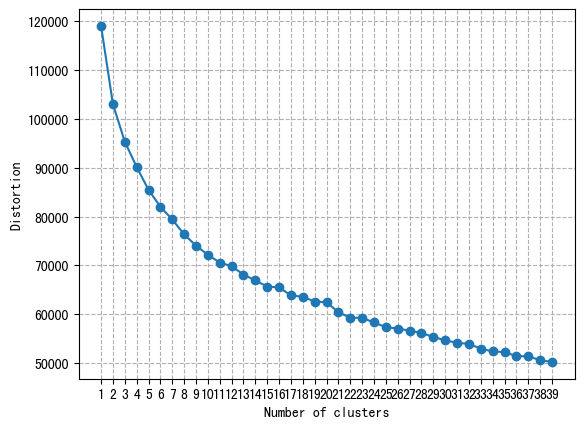

In [15]:
plt.plot(range(1, km_total), distortion, marker='o')
plt.xticks(range(1, km_total))
plt.grid(linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

In [16]:
Kmeans = KMeans(n_clusters=10, init="k-means++", algorithm='elkan').fit(data_sentences)
labels = Kmeans.labels_ 

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 591 / 591
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 100 iterations with early exaggeration: 62.246400
[t-SNE] KL divergence after 1000 iterations: 0.718859


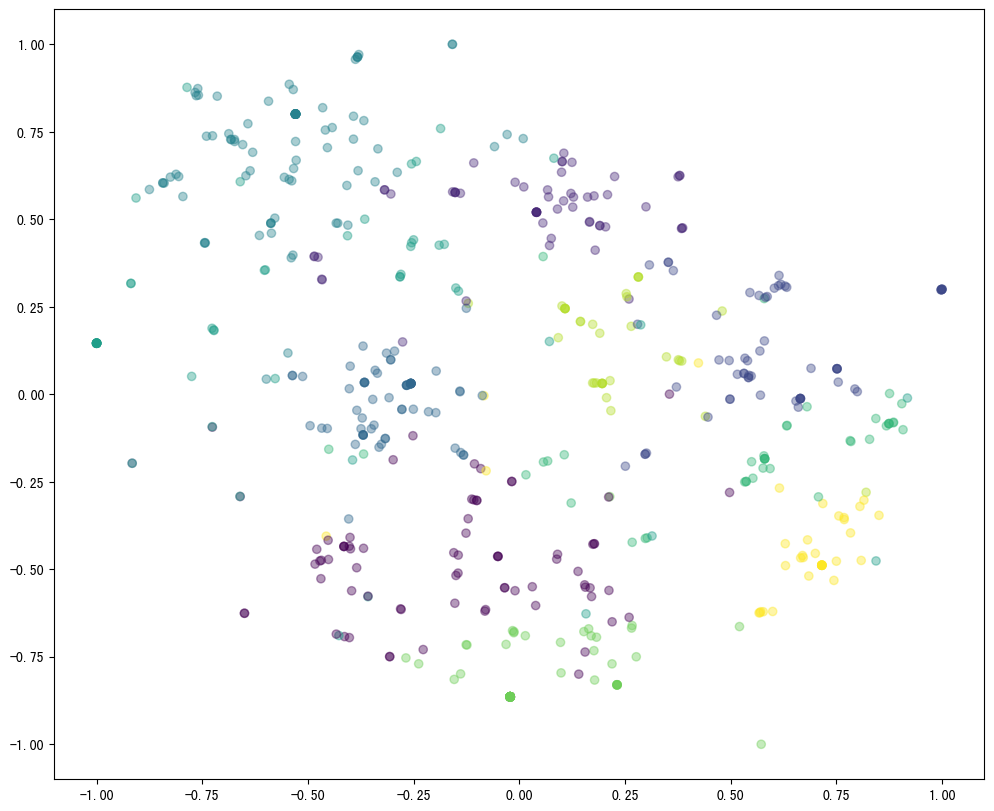

In [17]:
visual_model = TSNE(n_components=2, learning_rate='auto', init='random', verbose=1, random_state=233, method='exact')
# visual_model = TSNE(n_components=2, learning_rate='auto', init='random', 
#                     perplexity=40, early_exaggeration=20.0, method='exact')
visual = visual_model.fit_transform(data_sentences)

scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
visual = scaler.fit_transform(visual)

plt.figure(figsize=(12, 10))
plt.scatter(visual[:, 0], visual[:, 1], c=labels[:], alpha=0.4)
plt.show()

In [18]:
# pca = PCA(n_components=2, svd_solver='randomized', random_state=0) #实例化
# pca = pca.fit(data_sentences) #拟合模型
# visual = pca.transform(data_sentences) #获取新矩阵

visual_model = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, method='exact')
# visual_model = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=0, method='exact')
# visual_model = TSNE(n_components=2, learning_rate='auto', init='random', 
#                     perplexity=40, early_exaggeration=20.0, method='exact')
visual = visual_model.fit_transform(data_sentences)

scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
visual = scaler.fit_transform(visual)

# Kmeans = KMeans(n_clusters=len(position_classes)).fit(visual)
# labels = Kmeans.labels_ 

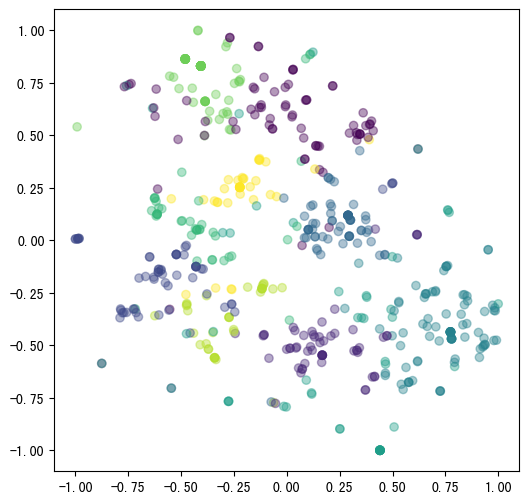

In [19]:
colors = ['r', 'g', 'w', 'b', 'k', 'w', 'pink', 'y', 'g'] * 3
# fig = plt.figure(figsize=(10, 10))
# ax = fig.gca(projection="3d")``
# ax.scatter(visual[:, 0], visual[:, 1],  visual[:, 2], c=labels[:], alpha=0.4)
plt.figure(figsize=(6, 6))
plt.scatter(visual[:, 0], visual[:, 1], c=labels[:], alpha=0.4)
plt.show()

In [26]:
# scatter = (
#         Scatter(init_opts=opts.InitOpts(width="1200px", height="800px"))
#         .add_xaxis([float(item) for item in visual[:, 0].tolist()])
#         .add_yaxis("",
#             [float(item) for item in visual[:, 1].tolist()]
#             )
#         .set_global_opts(
#             title_opts=opts.TitleOpts(title="Scatter-VisualMap(Color)"),
#             # visualmap_opts=opts.VisualMapOpts(max_=150),
#         )
# )
# scatter.render_notebook()

In [61]:
from itertools import cycle

In [62]:

plt.scatter(visual[:, 0], visual[:, 1], c=colors.next(), alpha=0.4)
plt.show()

AttributeError: 'itertools.cycle' object has no attribute 'next'

In [50]:
visual = np.around(visual, 1)

In [58]:
data = np.array([
    [-10.1, 8.04],
    [8.2, 6.95],
    [13.3, 7.58],
    [9.4, 8.81],
    [11.5, -8.33],
    [14.6, 9.96],
    [6.1, 7.24],
    [4.2, 4.26],
    [12.3, 10.84],
    [7.4, 4.82],
    [5.5, 5.68],
])
print(data[:10, 0], type(data))
print(data[:10, 1], type(data))

print(visual[:10, 0].tolist(), type(visual))
print(visual[:10, 1], type(visual))

scatter = (
        Scatter(init_opts=opts.InitOpts(width="1200px", height="800px"))
        .add_xaxis(visual[:2, 0].tolist())
        .add_yaxis("",
            visual[:2, 1].tolist(),
            symbol_size=20
            )
        .set_global_opts(
            title_opts=opts.TitleOpts(title="Scatter-VisualMap(Color)"),
            visualmap_opts=opts.VisualMapOpts(max_=150),
        )
)
# scatter.render_notebook()
scatter.render('test.html')

[-10.1   8.2  13.3   9.4  11.5  14.6   6.1   4.2  12.3   7.4] <class 'numpy.ndarray'>
[ 8.04  6.95  7.58  8.81 -8.33  9.96  7.24  4.26 10.84  4.82] <class 'numpy.ndarray'>
[6.300000190734863, 13.0, -9.899999618530273, 38.70000076293945, 1.7000000476837158, 7.599999904632568, -5.599999904632568, -9.800000190734863, 15.300000190734863, 13.800000190734863] <class 'numpy.ndarray'>
[ 35.2 -32.4 -50.3  27.6  24.   17.4  23.9  42.6 -34.1 -33.9] <class 'numpy.ndarray'>


'/home/vmice/projects/Recruitment-Data-Analysis/analysis/test.html'

In [88]:
c = (
    Scatter()
    .add_xaxis(xaxis_data=x_data)
    .add_yaxis(
        series_name="",
        y_axis=y_data,
        symbol_size=150,
        label_opts=opts.LabelOpts(is_show=False),
    )
    .set_series_opts()
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(
            type_="value", 
            splitline_opts=opts.SplitLineOpts(is_show=True)
        ),
        yaxis_opts=opts.AxisOpts(
            type_="value",
            axistick_opts=opts.AxisTickOpts(is_show=True),
            splitline_opts=opts.SplitLineOpts(is_show=True),
        ),
        tooltip_opts=opts.TooltipOpts(is_show=False),
    )
)
c.render_notebook()

In [76]:
from pyecharts.charts import Bar
from pyecharts import options as opts
 
bar = (
    Bar()
    .add_xaxis(["衬衫", "羊毛衫", "雪纺衫", "裤子", "高跟鞋", "袜子"])
    .add_yaxis("商家A", [5, 20, 36, 10, 75, 90])
    .set_global_opts(title_opts=opts.TitleOpts(title="主标题", subtitle="副标题"))
)
bar.render_notebook()

In [7]:
bar = Bar()
bar.add_xaxis(["衬衫", "羊毛衫", "雪纺衫", "裤子", "高跟鞋", "袜子"])
bar.add_yaxis("商家A", [5, 20, 36, 10, 75, 90])
bar.set_global_opts(title_opts=opts.TitleOpts(title="主标题", subtitle="副标题"))
bar.render_notebook()